---
## ODF Classifier with BioBERT  
---
### Content
---

- **[Libraries to use](#Libraries_to_use)**

- **[Loading the dataset](#Loading_dataset)**

- **[Cleaning the dataset and extracting required features](#Cleaning_extracting)**

- **[Including reversed findings to the dataset](#Reversed_findings)**

- **[Creating a dictionary with train, test, validation datasets](#train_test_validation)**

- **[Load tokenizer and model](#tokenizer_model)**

- **[Tokenize the datasets](#tokenize)**

- **[Formating to torch](#Formating)**

- **[Extracting hidden states](#Extracting_hidden_states)**

- **[Creating a feature matrix](#feature_matrix)**

- **[Visualizing the training set](#Visualizing_training)**

- **[Training a classifier](#Training_classifier)**

 ---

---
### Libraries to use <a id="Libraries_to_use"> </a>
---

In [1]:
#------------------------------------------------------
# Regular modules
#------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#------------------------------------------------------
# To avoid warnings
#------------------------------------------------------
import os
import warnings 
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#------------------------------------------------------
# Not regular modules
#------------------------------------------------------
import datasets
import torch
from umap import UMAP
from transformers import AutoTokenizer, AutoModel
#------------------------------------------------------
# Created modules
#------------------------------------------------------
from Classifier import data_cleaning  
from Classifier import including_reversing 
from Classifier import train_test_validation  

---
### Loading the dataset <a id="Loading_dataset"> </a>
---

In [31]:
real = pd.read_csv("../data/UpperGI.csv")
real  =real.rename(columns={"out":"text"})
real = data_cleaning(real)
real = real[['findings']]
real['label'] = 0
real=real.iloc[0:1000]

In [32]:
real#.head()

,findings,label
0,Columnar lined oesophagus is present. The segm...,0
1,There is an ulcer in the stomach which is supe...,0
2,LA Grade D oesophagitis. The oesopahgitis is ...,0
3,There is a polyp in the body which is sessile ...,0
4,There is a stricture in the fundus which is Oe...,0
...,...,...
995,There is inflammation in the body which is ero...,0
996,The patient has a stricture in the fundus whic...,0
997,The patient has a polyp in the stomach which i...,0
998,Several white exudates were seen. A whitish ex...,0


In [33]:
def cleaning_generated_data(fake):
    fake=fake.rename(columns={"generated_findings":"findings"})
    def regex_findings(string):
        line=ast.literal_eval(string)
        output =line[0]['generated_text']
        hospital_reg = r"\.*FINDINGS:.*"
        output = re.findall(hospital_reg, output)[0][10:]
        return output
    fake["findings"] = fake['findings'].apply(regex_findings)
    fake['label'] = 1
    return fake

In [34]:
fake_1 = pd.read_csv("../data/findings1000.csv")
fake_1 = cleaning_generated_data(fake_1)
fake_1 = fake_1[['findings']]
fake_1['label'] = 1



In [36]:
fake_1[0:1000]

,findings,label
0,The patient has a 6mm nodule in the duodenal ...,1
1,The patient has inflammation in the oesophagu...,1
2,There is a nodule in the GOJ which is stalked...,1
3,Normal gastroscopy to the duodenum..,1
4,There is inflammation in the oesophagus at 27...,1
...,...,...
995,The patient has a stricture in the second par...,1
996,Normal gastroscopy to the duodenum. FOLLOW,1
997,The patient has a polyp in the stomach which ...,1
998,Inflammatory changes seen in the oesophagus. ...,1


In [37]:
fake_1['findings'].loc[12]

' There is a nodule in the stomach which is stalked. A nodular lesion is observed in the gastric fundus'

---
### Including reversed findings to the dataset <a id="Reversed_findings"> </a>
---

In [40]:
fake_real = pd.concat([fake_1[:1000], real])

In [41]:
fake_real.reset_index(drop=True, inplace=True)
fake_real

,findings,label
0,The patient has a 6mm nodule in the duodenal ...,1
1,The patient has inflammation in the oesophagu...,1
2,There is a nodule in the GOJ which is stalked...,1
3,Normal gastroscopy to the duodenum..,1
4,There is inflammation in the oesophagus at 27...,1
...,...,...
1995,There is inflammation in the body which is ero...,0
1996,The patient has a stricture in the fundus whic...,0
1997,The patient has a polyp in the stomach which i...,0
1998,Several white exudates were seen. A whitish ex...,0


In [42]:
# sentences.tail(3)

---
### Creating a dictionary with train, test, validation datasets <a id="train_test_validation"> </a>
---

In [43]:
Dict_datasets = train_test_validation(fake_real)

In [44]:
Dict_datasets

DatasetDict({
    train: Dataset({
        features: ['findings', 'label'],
        num_rows: 980
    })
    test: Dataset({
        features: ['findings', 'label'],
        num_rows: 600
    })
    validation: Dataset({
        features: ['findings', 'label'],
        num_rows: 420
    })
})

---
### Load tokenizer and model <a id="tokenizer_model"> </a>
---

- BioBERT is a pre-trained language model that is designed for biomedical natural language processing (NLP) tasks. It is based on the Google's BERT (Bidirectional Encoder Representations from Transformers) architecture.

- BioBERT is pre-trained on a large corpus of biomedical text data, which includes abstracts and full-text articles from PubMed Central and other biomedical databases. 

---

In [45]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

In [46]:
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1", num_labels=2)

---
### Tokenize the datasets <a id="tokenize"> </a>
---

In [47]:
#--------------------------------------------------------------------
# define function to tokenize the datasets
#--------------------------------------------------------------------
def tokenize(data):
    return tokenizer(data["findings"], padding=True, truncation=True,max_length=10) 
#--------------------------------------------------------------------
# tokenize datasets
#--------------------------------------------------------------------
Dict_datasets_encoded = Dict_datasets.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/980 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

---
### Formating to torch <a id="Formating"> </a>
---

In [48]:
Dict_datasets_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

---
### Extracting hidden states <a id="Extracting_hidden_states"> </a>
---

How will extract the hidden states associated with each finding.

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
dataset_hidden = Dict_datasets_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/980 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

---
### Creating a feature matrix <a id="feature_matrix"> </a>
---

We will use the hidden states as input features and the labels as targets.

In [50]:
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])
X_train.shape, X_valid.shape, X_test.shape

((980, 768), (420, 768), (600, 768))

In [51]:
#feature_matrix_list = [X_train,X_valid,X_test,y_train,y_valid,y_test]

In [52]:
#np.save('feature_matrix_list.npy', np.array(feature_matrix_list, dtype=object), allow_pickle=True)

In [53]:
#feature_matrix_list_loaded = np.load('feature_matrix_list.npy', allow_pickle=True)
#[X_train,X_valid,X_test,y_train,y_valid,y_test]=feature_matrix_list_loaded

---
### Visualizing the training set <a id="Visualizing_training"> </a>
---

In [54]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,10.427748,-1.850638,0
1,-18.721735,19.381409,0
2,-13.347418,-13.642392,1
3,27.238203,8.491126,1
4,0.479164,7.727686,1


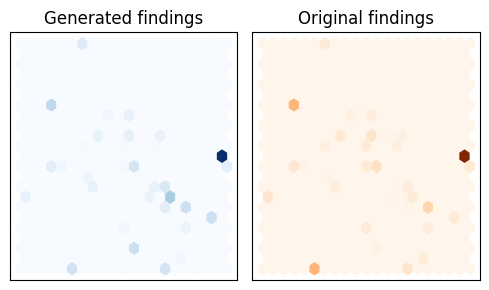

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(5,3))
axes = axes.flatten()
cmaps = ["Blues", "Oranges"]
labels = ['Generated findings','Original findings']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

---
### Training a classifier <a id="Training_classifier"> </a>
---

In [56]:
lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6238095238095238

In [86]:
y_preds = lr_clf.predict(X_test[0:1,:])
y_preds

array([1])

In [85]:
y_test[0]

1

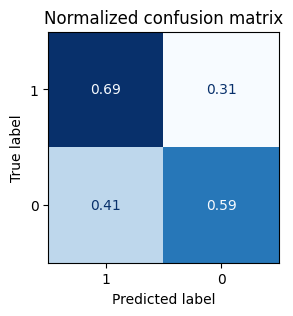

In [57]:
y_preds = lr_clf.predict(X_test)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(3, 3))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_test,y_preds, [1,0])

In [58]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_preds)

0.6216666666666667

### Classification of a single text

In [59]:
labels = ['"Real" medical report','Fake medical report']

In [143]:
fake_1['findings'].iloc[item]

' Normal gastroscopy to the duodenum. character (0)'

#----------------------------------------------------------------------------------------
# Text
#----------------------------------------------------------------------------------------
 Normal gastroscopy to the duodenum. character (0)
#----------------------------------------------------------------------------------------
# Label
#----------------------------------------------------------------------------------------
Fake medical report
#----------------------------------------------------------------------------------------


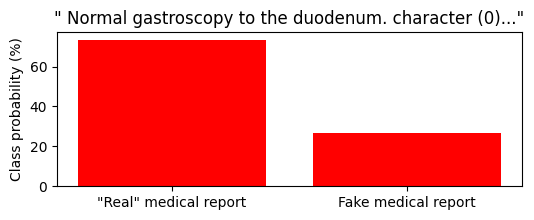

array([0])

In [142]:
item=500
print('#----------------------------------------------------------------------------------------')
print('# Text')
print('#----------------------------------------------------------------------------------------')
custom_label = fake_1['label'].iloc[item]
custom_sentence=fake_1['findings'].iloc[item]
print(custom_sentence)
print('#----------------------------------------------------------------------------------------')
print('# Label')
print('#----------------------------------------------------------------------------------------')
print(labels[custom_label])
print('#----------------------------------------------------------------------------------------')
#-----------------------------------------------------
#-----------------------------------------------------
inputs = tokenizer(custom_sentence, return_tensors="pt")
#-----------------------------------------------------
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
        outputs = model(**inputs)
#outputs.last_hidden_state.shape
#-----------------------------------------------------
preds_prob = lr_clf.predict_proba(np.array(outputs.last_hidden_state[:,0].cpu().numpy()))
preds = lr_clf.predict(np.array(outputs.last_hidden_state[:,0].cpu().numpy()))
#-----------------------------------------------------
#preds_df = pd.DataFrame(preds[0])
#-----------------------------------------------------
plt.figure(figsize=(6,2))
plt.bar(labels, 100 * preds_prob[0], color='red')
plt.title(f'"{custom_sentence[:110]}..."')
plt.ylabel("Class probability (%)")
plt.show()
preds

In [131]:
preds

array([0])

In [132]:
preds_prob

array([[0.69998029, 0.30001971]])